# **Thư viện**

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error


# **Dữ liệu**

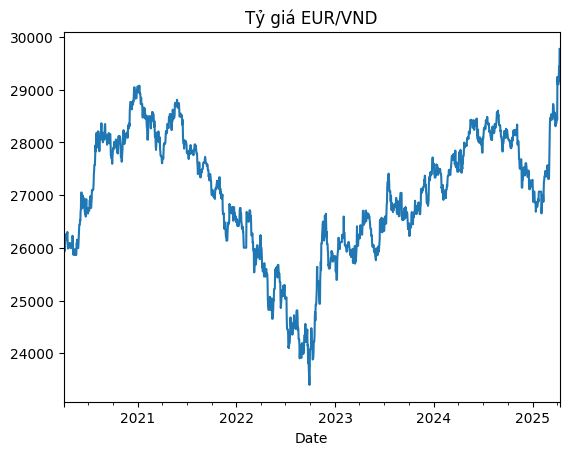

In [12]:
df = pd.read_csv(r"D:\eur-vnd-exchange-rate\data\processed\EUR_VND_Exchange_Rate.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

y = df['Sell']
y.plot(title="Tỷ giá EUR/VND")
plt.show()

In [13]:
df.tail(2)

,Sell
Date,
2025-04-10,29178.76
2025-04-11,29775.69


# **Phân tích thành phần mùa (Seasonal Decomposition)**

<Figure size 1400x1000 with 0 Axes>

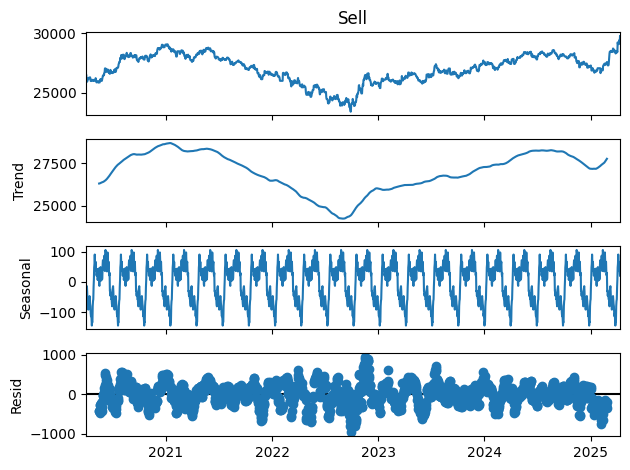

In [14]:
decomposition = seasonal_decompose(y, model='additive', period=90)  # period=90 vì dữ liệu theo ngày
plt.figure(figsize=(14, 10))
decomposition.plot()
plt.tight_layout()
plt.show()

# **Kiểm tra tính dừng (ADF Test)**


In [15]:
result = adfuller(y)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

if result[1] < 0.05:
    print("Chuỗi dừng")
else:
    print("Chuỗi không dừng, cần lấy sai phân")

ADF Statistic: -1.2253450973203506
p-value: 0.6625989844374176
Chuỗi không dừng, cần lấy sai phân


## **Lấy sai phân**

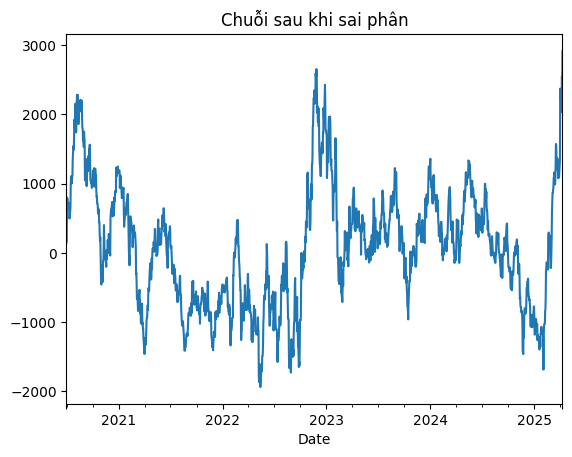

In [16]:
y_diff = y.diff(90).dropna()
y_diff.plot(title="Chuỗi sau khi sai phân")
plt.show()

In [17]:
result = adfuller(y_diff)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

if result[1] < 0.05:
    print("Chuỗi dừng")
else:
    print("Chuỗi không dừng, cần lấy sai phân")

ADF Statistic: -2.7937578136678862
p-value: 0.059170966993508135
Chuỗi không dừng, cần lấy sai phân


# **ACF và PACF để chọn p, q**

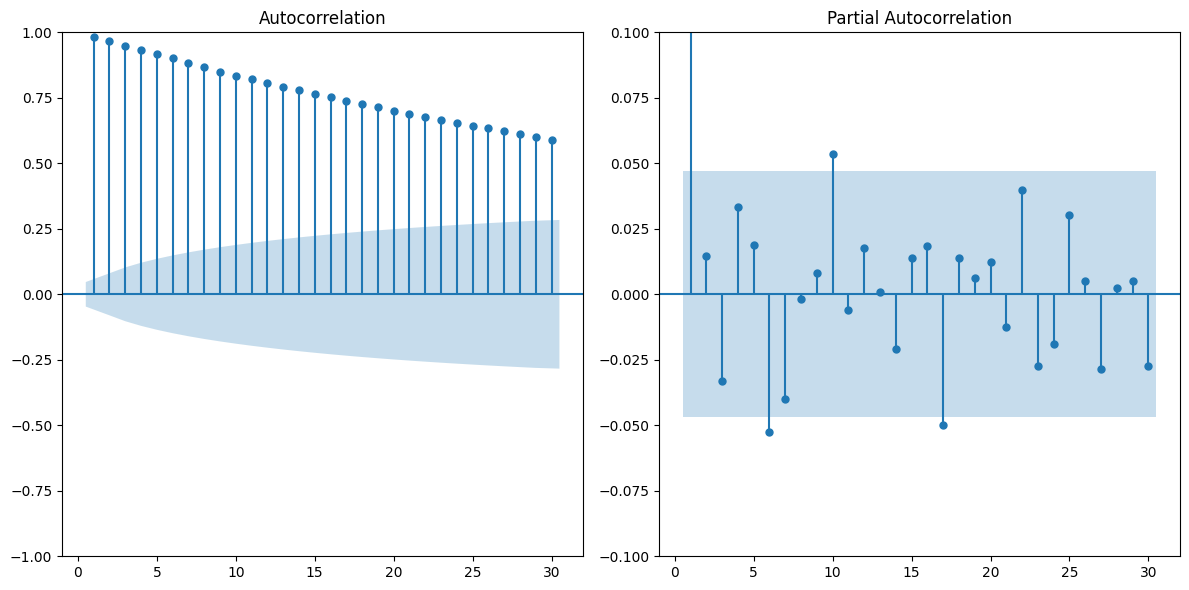

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
_ = plot_acf(y_diff, ax=ax1, lags=30, zero=False)
_ = plot_pacf(y_diff, ax=ax2, lags=30, zero=False)

ax1.set_ylim(-1, 1)
ax2.set_ylim(-0.1, 0.1)

plt.tight_layout()
plt.show()


# **Mô hình SARIMA**

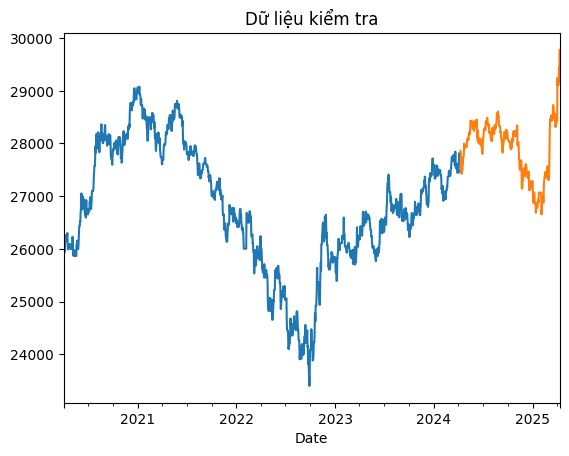

In [19]:
train_size = int(len(y) * 0.8)
train, test = y[:train_size], y[train_size:]

train.plot(title="Dữ liệu huấn luyện")
test.plot(title="Dữ liệu kiểm tra")
plt.show()

In [20]:
# Fit mô hình SARIMA (p, d, q, P, D, Q, s)
# Ví dụ: (1, 1, 1)x(1, 1, 1, 90) 
# 90 là số ngày trong một quý, nghĩa là mùa có chu kỳ 90 ngày
model = SARIMAX(train, order=(1, 1, 6), seasonal_order=(1, 1, 0, 90))
result = model.fit()

c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [21]:
print(result.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                Sell   No. Observations:                 1469
Model:             SARIMAX(1, 1, 6)x(1, 1, [], 90)   Log Likelihood               -8681.016
Date:                             Mon, 14 Apr 2025   AIC                          17380.032
Time:                                     14:40:21   BIC                          17427.087
Sample:                                 04-01-2020   HQIC                         17397.636
                                      - 04-08-2024                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4107     15.715      0.026      0.979     -30.391      31.212
ma.L1         -0.3785     1

# **Đánh giá mô hình**

In [22]:
y_pred = result.forecast(steps=len(test))

MAE = mean_absolute_error(test, y_pred)
MSE = mean_squared_error(test, y_pred)
RMSE = np.sqrt(MSE)
MAPE = np.mean(np.abs((test - y_pred) / test)) * 100

print(f"MAE: {MAE}")
print(f"MSE: {MSE}")
print(f"RMSE: {RMSE}")
print(f"MAPE: {MAPE}%")

MAE: 984.7625655085936
MSE: 1680009.5809216343
RMSE: 1296.1518355970625
MAPE: 3.5748412549042943%


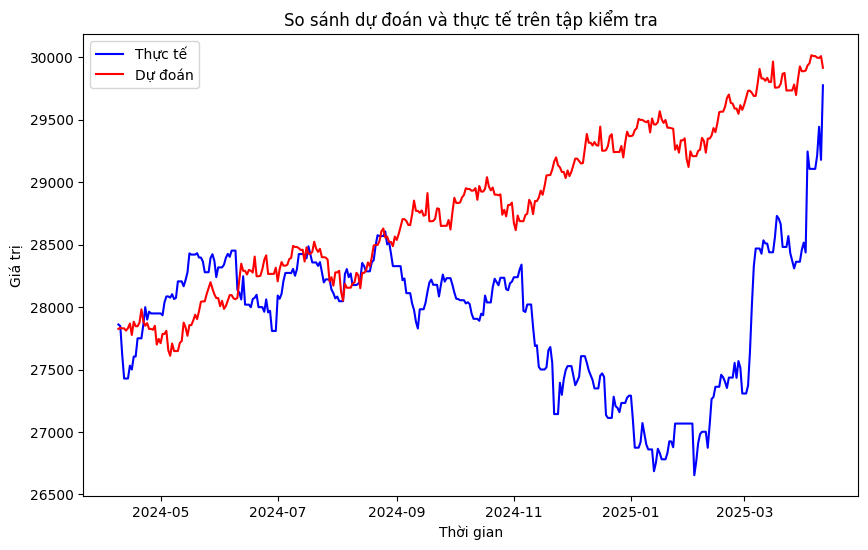

In [23]:
# Vẽ biểu đồ so sánh thực tế và dự báo
plt.figure(figsize=(10, 6))
plt.plot(test, label='Thực tế', color='blue')
plt.plot(y_pred, label='Dự đoán', color='red')
plt.title('So sánh dự đoán và thực tế trên tập kiểm tra')
plt.xlabel('Thời gian')
plt.ylabel('Giá trị')
plt.legend()
plt.show()